# SpareRoom


In [43]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import folium
import json

<h1> London

<h2> Web Scraping housing info in London

In [44]:
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Second Type of housing
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Third type of housing:
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
#     Turn to next page and get more housings
    if soup.find('ul',class_='navnext'):
        if soup.find('ul',class_='navnext').find('a'):
            next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
            next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
        # Use recursion to get all the attractions    
            housings_list.extend(get_housings(next_page))
    return housings_list


In [45]:
url_london = 'https://www.spareroom.co.uk/flatshare/?search_id=745817425&'
list_ = get_housings(url_london)
print(f'We have find {len(list_)} results for you.')

We have find 1100 results for you.


In [46]:
def get_details(list_housings):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_housings:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        # price 这里似乎有个bug，但是我暂时懒得改
        if soup.find('h3', class_='feature__heading'):
            price_list.append(soup.find('h3', class_='feature__heading').get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
    return full_dict
        

In [47]:
list_housings = list_
dict_ = get_details(list_housings)

<h3> Clean the data

In [48]:
for key in dict_.keys():
    for subkey in dict_[key].keys():
        if isinstance(dict_[key][subkey], str):
            dict_[key][subkey] = dict_[key][subkey].lstrip().rstrip()
# Clean the price list
for key in dict_.keys():
    list_in = list()
    for item in list(dict_[key]['Price']):
        list_in.append(item.strip('\n'))
    dict_[key]['Price'] = list_in

<h3> Create a dataframe to store the info

In [49]:
df_info = pd.DataFrame(dict_)
df_info = df_info.T

# Fix furnished problem
for i in df_info.index:
    if df_info.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
        pass
    else:
        df_info.iloc[i]['Furnishing'] = 'No info'
# Fix Gender_requirement problem
for i in df_info.index:
    if not df_info.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info',
       'Male preferred']:
        df_info.iloc[i]['Gender_requirement'] = 'No info'

In [50]:
# Create a new col in df_info to store average price for a single person
pattern = r'\d+'  
price_per_month = list()

for i in df_info.index:
    list_in_price = list()
    for item in df_info.iloc[i]['Price']:
        item = item.replace(',', '')
        if 'pw' in item:
            price_info = int((re.findall(pattern, item))[0])
            list_in_price.append(price_info*4)
        if 'pcm' in item:
            price_info = int((re.findall(pattern, item))[0])
            list_in_price.append(price_info)
    price_per_month.append(list_in_price)
price_per_month = np.array(price_per_month)
df_info['Price_per_month'] = price_per_month
list_avg_price = list()
for i in df_info.index:
    list_avg_price.append(np.mean(df_info.iloc[i]['Price_per_month']) )
df_info['Average_price_per_month'] = np.array(list_avg_price)
# Create a new col in df_info to store zip code for each housing


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
# Create a new col for zip code
list_pos = list()
for i in df_info.index:
    for s in df_info.iloc[i]['Location']:
        if s == '(':
            position = df_info.iloc[i]['Location'].index(s)
            break
    list_pos.append(df_info.iloc[i]['Location'][position:].strip('(').strip(')'))
df_info['Postal_code'] = np.array(list_pos)

In [52]:
df_info

,Availablility,Furnishing,Gender_requirement,Location,Max_period,Min_period,Price,Short_description,Size,Price_per_month,Average_price_per_month,Postal_code
0,Now,Furnished,Males or females,Balham (SW17),None,12 months,"[£1,127 pcm, £320 pw, £1,191 pcm, £1,213 pcm, ...",Home sweet home,Double room,"[1127, 1280, 1191, 1213, 1235, 1213]",1209.833333,SW17
1,Now,Furnished,Males or females,Tooting Broadway (SW17),None,6 months,"[£1,025 pcm, £975 pcm]","Social Living, Beautiful house, All bills Incl...",2 doubles,"[1025, 975]",1000.000000,SW17
2,Now,Furnished,Males or females,London E3 (E3),None,3 months,[£650 pcm],ðCheap & Bright Double Room in E3-Zone 2ð,Double room,[650],650.000000,E3
3,17 Dec 2018,Furnished,Males or females,London E1 (E1),None,3 months,[£750 pcm],Stunning Double Room in Liverpool Street Area,Double room,[750],750.000000,E1
4,02 Dec 2018,Furnished,Males or females,Canary Wharf (E14),None,3 months,[£650 pcm],ð¡Special Semi-Double Room in Canary Wharfð¡,Double room,[650],650.000000,E14
5,01 Dec 2018,Furnished,No info,London Bridge (SE1),None,6 months,"[£1,650 pcm (whole property)]",Fully furnished 1st floor flat in london bridge.,1 bed flat,[1650],1650.000000,SE1
6,06 Dec 2018,Furnished,Males or females,Wood Green (N22),None,3 months,[£625 pcm],Brand New Double Room in Modern House,Double room,[625],625.000000,N22
7,01 Dec 2018,Furnished,Males or females,Old Street (N1),None,6 months,"[£200 pw, £210 pw, £225 pw]",3 Bedrooms - Old Street - Furnishd - Bills Incl.,3 doubles,"[800, 840, 900]",846.666667,N1
8,Now,Furnished,Males or females,Streatham (SW16),None,6 months,[£750 pcm],Large double in friendly houseshare with garden,Double room,[750],750.000000,SW16
9,01 Feb 2019,Furnished,Males or females,Earl's Court (SW5),None,12 months,[£625 pcm],"Cosy, bright room in amazing flat in Earls Court",Single room,[625],625.000000,SW5


<h4> Create a function for the above

In [53]:
# Create a function for the above:
def clean(dict_):
    for key in dict_.keys():
        for subkey in dict_[key].keys():
            if isinstance(dict_[key][subkey], str):
                dict_[key][subkey] = dict_[key][subkey].lstrip().rstrip()
    # Clean the price list
    for key in dict_.keys():
        list_in = list()
        for item in list(dict_[key]['Price']):
            list_in.append(item.strip('\n'))
        dict_[key]['Price'] = list_in
        
    df_info = pd.DataFrame(dict_)
    df_info = df_info.T

    # Fix furnished problem
    for i in df_info.index:
        if df_info.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
            pass
        else:
            df_info.iloc[i]['Furnishing'] = 'No info'
    # Fix Gender_requirement problem
    for i in df_info.index:
        if df_info.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info','Male preferred']:
            pass
        else:
            df_info.iloc[i]['Gender_requirement'] = 'No info'
    # Create a new col in df_info to store average price for a single person
    pattern = r'\d+'  
    price_per_month = list()

    for i in df_info.index:
        list_in_price = list()
        for item in df_info.iloc[i]['Price']:
            item = item.replace(',', '')
            if 'pw' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info*4)
            if 'pcm' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info)
        price_per_month.append(list_in_price)
    price_per_month = np.array(price_per_month)
    df_info['Price_per_month'] = price_per_month
    list_avg_price = list()
    for i in df_info.index:
        list_avg_price.append(np.mean(df_info.iloc[i]['Price_per_month']) )
    df_info['Average_price_per_month'] = np.array(list_avg_price)
    # Create a new col in df_info to store zip code for each housing
    # Create a new col for zip code
    list_pos = list()
    for i in df_info.index:
        for s in df_info.iloc[i]['Location']:
            if s == '(':
                position = df_info.iloc[i]['Location'].index(s)
                break
        list_pos.append(df_info.iloc[i]['Location'][position:].strip('(').strip(')'))
    df_info['Postal_code'] = np.array(list_pos)
    return df_info
      

<h3> Data Visualization

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')# seaborn is a style that have different colors

<h4> To see if there is a gender preference in London

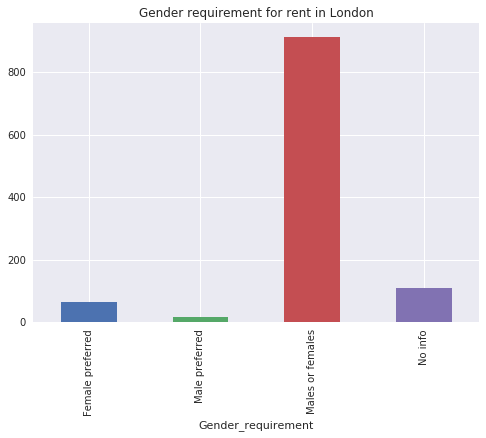

In [55]:
gender_group = df_info.groupby('Gender_requirement')
gender_group.size().plot(kind='bar', title='Gender requirement for rent in London')

<h4> To see the housing condition in postal code area in London

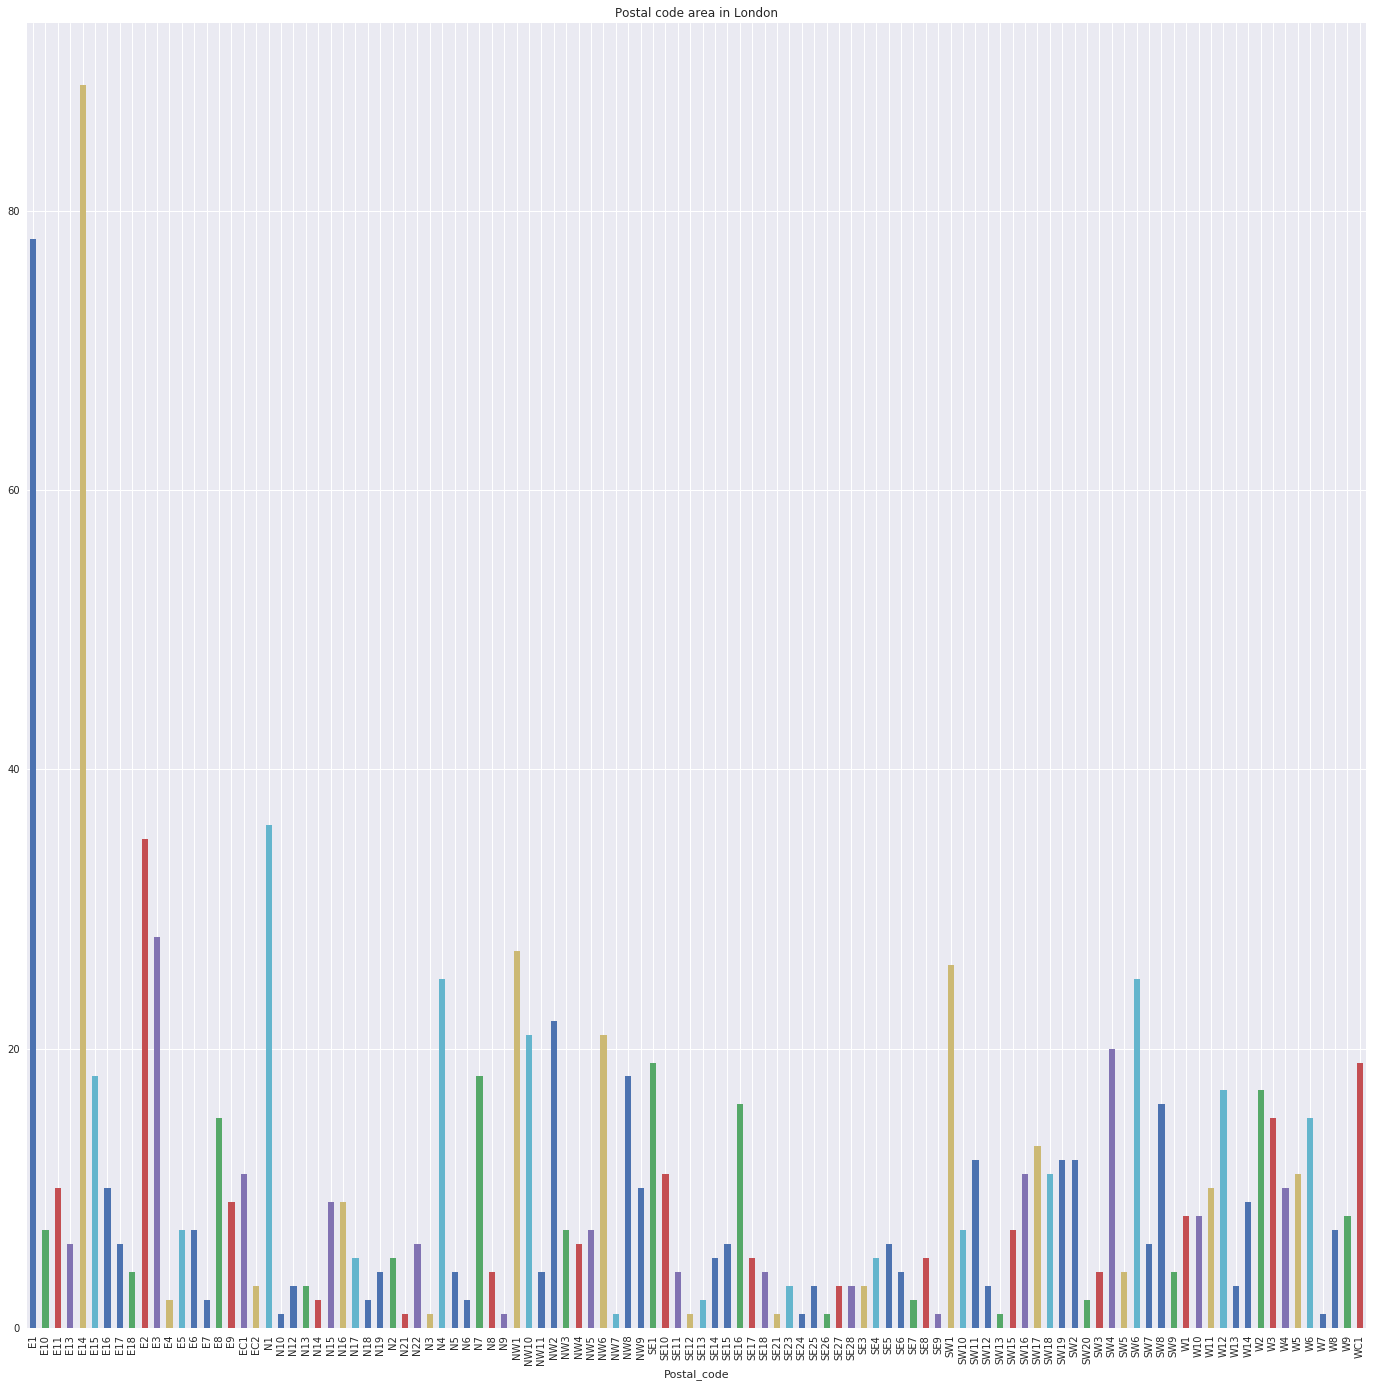

In [56]:
Postal_code_group = df_info.groupby('Postal_code')
Postal_code_group.size().plot(kind='bar', title='Postal code area in London', figsize=(24,24))

<h4> To see if there is more furnished apartment in London

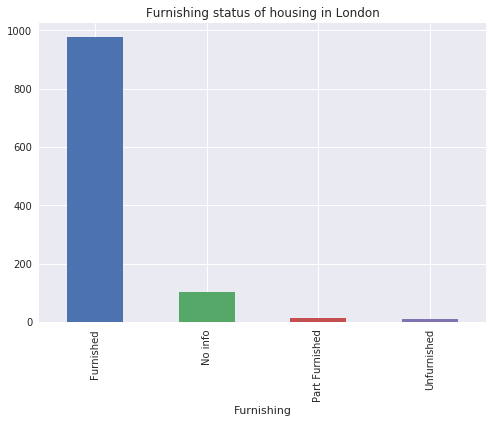

In [57]:
furnish_group = df_info.groupby('Furnishing')
furnish_group.size().plot(kind='bar', title='Furnishing status of housing in London')

<h4> To see the size distribution in London

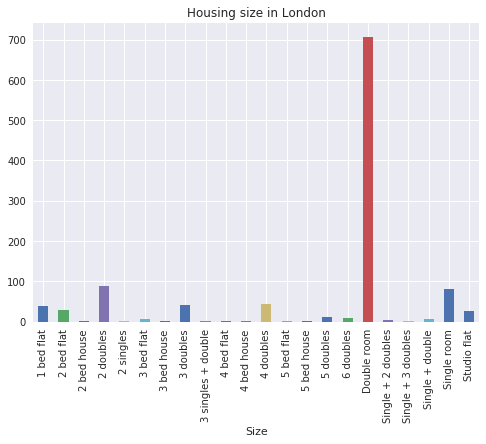

In [58]:
size_group = df_info.groupby('Size')
size_group.size().plot(kind='bar', title='Housing size in London')

<h4> To see the average per-month price change

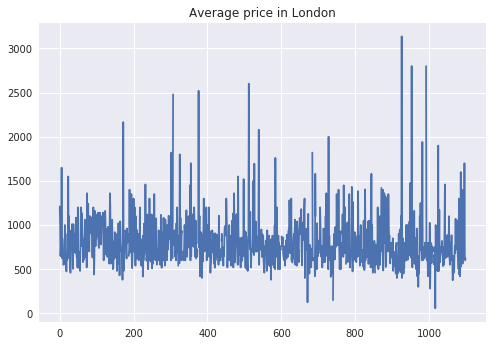

In [59]:
df_info['Average_price_per_month'].plot(kind='line', title='Average price in London')

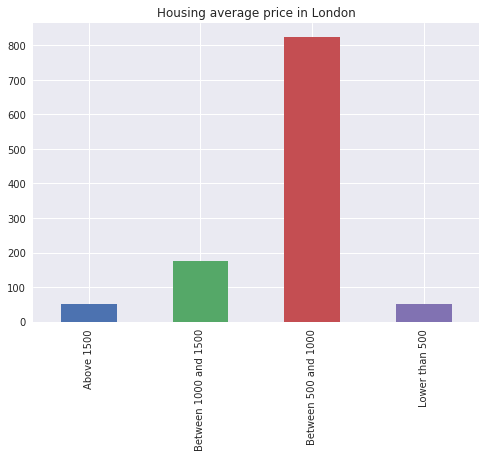

In [60]:
# Group the average price
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] < 500:
        return 'Lower than 500'
    elif 1000 > df[col].loc[ind] >= 500:
        return 'Between 500 and 1000'
    elif 1500 > df[col].loc[ind] >= 1000:
        return 'Between 1000 and 1500'
    else:
        return 'Above 1500'
avg_price_group = df_info.groupby(lambda x: GroupColFunc(df_info, x, 'Average_price_per_month')) 
avg_price_group.size().plot(kind='bar', title='Housing average price in London')
# Add a col of average price group for further analysis
avg_price_list = list()
for i in df_info.index:
    avg_price_list.append(GroupColFunc(df_info, i, 'Average_price_per_month'))
df_info['Avg_price_group'] = np.array(avg_price_list)

In [61]:
# Group by both size and average price
size_avg_groups = df_info.groupby(['Size','Avg_price_group']).size().unstack()

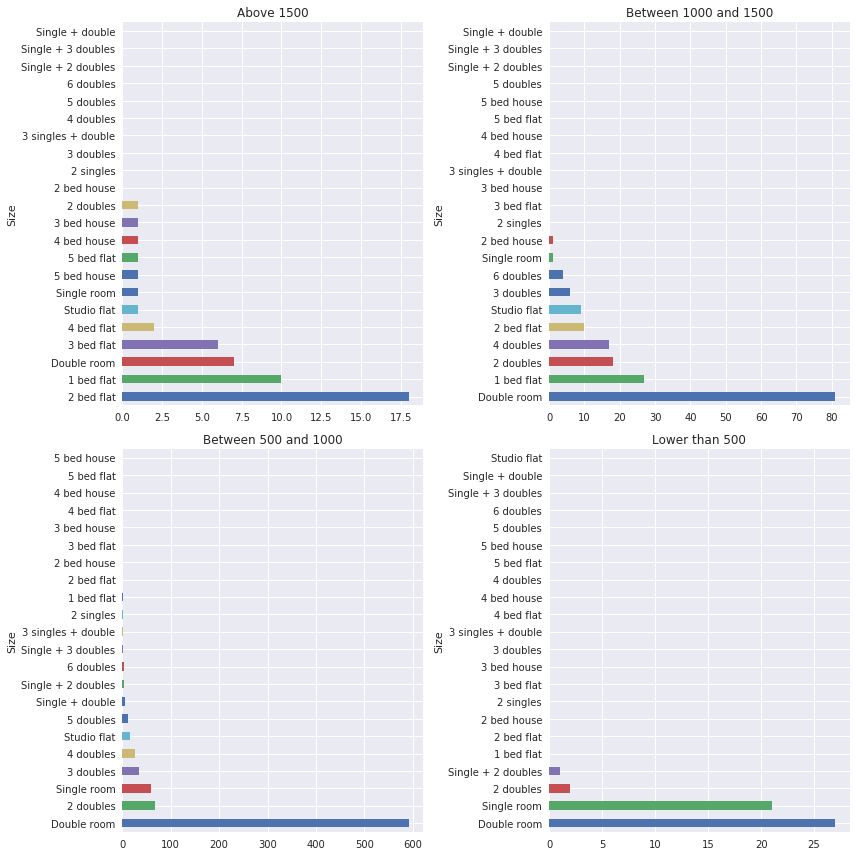

In [62]:
COL_NUM = 2
ROW_NUM = 2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (avg, size) in enumerate(size_avg_groups.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    size = size.sort_values(ascending=False) # sort the data in descending order 
    size.plot(kind='barh', ax=ax)
    ax.set_title(avg)

plt.tight_layout() 

<h3> Heat Map

In [63]:
m = folium.Map(location = [51.5074, 0.1278],zoom_start=10)

In [64]:
zip_groups = df_info.groupby('Postal_code')
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)# Rename the col besides index to 'size'
sizes.reset_index(level=0, inplace=True)# level 0 here means no index,the index becomes row number
sizes['Zip'] = sizes['Postal_code']
sizes.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
Postal_code    108 non-null object
size           108 non-null int64
Zip            108 non-null object
dtypes: int64(1), object(2)
memory usage: 2.6+ KB


In [65]:
# read the geojson file and get all the postcode
with open("london_postcodes.geojson",'r') as load_f:
    load_dict = json.load(load_f)
full_pos = list()
for item in load_dict['features']:
    full_pos.append(item['properties']['Name'])


In [66]:
df_zip = pd.DataFrame(np.array([full_pos])).T
df_zip = df_zip.rename(columns={0:'Zip_code'})

In [67]:
zip_size = list()
for i in df_zip.index:
    for j in sizes.index:
        if df_zip.iloc[i]['Zip_code'] == sizes.iloc[j]['Zip']:
            zip_size.append(sizes.iloc[j]['size'])
            break
        elif j == (len(sizes) - 1):
            zip_size.append(0)
df_zip['size'] = np.array(zip_size)  

In [68]:
m.choropleth(geo_data='london_postcodes.geojson', data=df_zip, 
             columns=['Zip_code','size'],
             key_on='feature.properties.Name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of housing')
folium.LayerControl().add_to(m)

/usr/local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [69]:
m

<h4> Create a function for the above

In [70]:
# a function to use google api to get the lat and lng for a location
def get_lat_lng(address_string,api_key):
    url=f"https://maps.googleapis.com/maps/api/geocode/json?address={address_string}&key={api_key}" 
    import requests
    response = requests.get(url)
    if response.status_code != 200:
        print('Something went wrong about requests due to internet problem or typing error.')
    else:
        try:
            response_ = response.json()
        except:
            print("Sth wrong with json decoding process")
        return [response_['results'][0]['geometry']['location']['lat'],response_['results'][0]['geometry']['location']['lng']]

In [71]:
# All_above in one function 
def map_rent(location, df_info, api_key):
    location = location.lower() 
    api_key = api_key
    m = folium.Map(location = get_lat_lng(location,api_key),zoom_start=10)
    zip_groups = df_info.groupby('Postal_code')
    sizes = pd.DataFrame(zip_groups.size())
    sizes.rename(columns={0:"size"},inplace=True)# Rename the col besides index to 'size'
    sizes.reset_index(level=0, inplace=True)# level 0 here means no index,the index becomes row number
    sizes['Zip'] = sizes['Postal_code']
    # read the geojson file and get all the postcode
    with open(f"{location}_postcodes.geojson",'r') as load_f:
        load_dict = json.load(load_f)
    full_pos = list()
    for item in load_dict['features']:
        full_pos.append(item['properties']['Name'])
    df_zip = pd.DataFrame(np.array([full_pos])).T
    df_zip = df_zip.rename(columns={0:'Zip_code'})
    zip_size = list()
    for i in df_zip.index:
        for j in sizes.index:
            if df_zip.iloc[i]['Zip_code'] == sizes.iloc[j]['Zip']:
                zip_size.append(sizes.iloc[j]['size'])
                break
            elif j == (len(sizes) - 1):
                zip_size.append(0)
    df_zip['size'] = np.array(zip_size) 
    m.choropleth(geo_data=f'{location}_postcodes.geojson', data=df_zip, 
             columns=['Zip_code','size'],
             key_on='feature.properties.Name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of housing')
    folium.LayerControl().add_to(m)
    return m

    

<h1> Liverpool

In [12]:
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Second type
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Third type
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
#     Turn to next page and get more housings
    if soup.find('ul',class_='navnext'):
        if soup.find('ul',class_='navnext').find('a'):
            next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
            next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
        # Use recursion to get all the attractions    
            housings_list.extend(get_housings(next_page))
    return housings_list



In [13]:
url_liver = 'https://www.spareroom.co.uk/flatshare/?search_id=746073457&'
list_liver = get_housings(url_liver)
print(f'We have find {len(list_liver)} results for you.')

We have find 732 results for you.


In [ ]:
list_liver

In [ ]:
def get_details(list_housings):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_housings:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        # price 这里似乎有个bug，但是我暂时懒得改
        if soup.find('h3', class_='feature__heading'):
            price_list.append(soup.find('h3', class_='feature__heading').get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
    return full_dict
        

In [ ]:
list_housings_liver = list_liver
dict_liver = get_details(list_housings_liver)

In [ ]:
dict_liver

<h3>Clean the data

In [ ]:
for key in dict_liver.keys():
    for subkey in dict_liver[key].keys():
        if isinstance(dict_liver[key][subkey], str):
            dict_liver[key][subkey] = dict_liver[key][subkey].lstrip().rstrip()
# Clean the price list
for key in dict_liver.keys():
    list_in = list()
    for item in list(dict_liver[key]['Price']):
        list_in.append(item.strip('\n'))
    dict_liver[key]['Price'] = list_in

<h3>Create a dataframe to store the info

In [ ]:
df_info_liver = pd.DataFrame(dict_liver)
df_info_liver = df_info_liver.T

# Fix furnished problem
for i in df_info_liver.index:
    if df_info_liver.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
        pass
    else:
        df_info_liver.iloc[i]['Furnishing'] = 'No info'
# Fix Gender_requirement problem
for i in df_info_liver.index:
    if not df_info_liver.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info',
       'Male preferred']:
        df_info_liver.iloc[i]['Gender_requirement'] = 'No info'

In [ ]:
# Create a new col in df_info_liver to store average price for a single person
pattern = r'\d+'  
price_per_month = list()

for i in df_info_liver.index:
    list_in_price = list()
    for item in df_info_liver.iloc[i]['Price']:
        item = item.replace(',', '')
        if 'pw' in item:
            price_info = int((re.findall(pattern, item))[0])
            list_in_price.append(price_info*4)
        if 'pcm' in item:
            price_info = int((re.findall(pattern, item))[0])
            list_in_price.append(price_info)
    price_per_month.append(list_in_price)
price_per_month = np.array(price_per_month)
df_info_liver['Price_per_month'] = price_per_month
list_avg_price = list()
for i in df_info_liver.index:
    list_avg_price.append(np.mean(df_info_liver.iloc[i]['Price_per_month']) )
df_info_liver['Average_price_per_month'] = np.array(list_avg_price)
# Create a new col in df_info_liver to store zip code for each housing




In [ ]:
df_info_liver

In [ ]:
# Create a new col for zip code
list_pos = list()
for i in df_info_liver.index:
    for s in df_info.iloc[i]['Location']:
        if s == '(':
            position =df_info_liver.iloc[i]['Location'].index(s)
            break
    list_pos.append(df_info_liver.iloc[i]['Location'][position:].strip('(').strip(')'))
df_info_liver['Postal_code'] = np.array(list_pos)

<h3>Data Visualization

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')# seaborn is a style that have different colors

<h3>To see if there is a gender preference in Liverpool

In [ ]:
gender_group_liver = df_info_liver.groupby('Gender_requirement')
gender_group_liver.size().plot(kind='bar', title='Gender requirement for rent in Liverpool')

<h3>To see if there is more furnished apartment in Liverpool

In [ ]:
furnish_group_liver = df_info_liver.groupby('Furnishing')
furnish_group_liver.size().plot(kind='bar', title='Furnishing status of housing in Liverpool')

<h3>To see the size distribution in Liverpool 

In [ ]:
size_group_liver = df_info_liver.groupby('Size')
size_group_liver.size().plot(kind='bar', title='Housing size in Liverpool')

<h3>To see the average per-month price change

In [ ]:
df_info_liver['Average_price_per_month'].plot(kind='line', title='Average price in Liverpool')

In [ ]:
# Group the average price
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] < 500:
        return 'Lower than 500'
    elif 1000 > df[col].loc[ind] >= 500:
        return 'Between 500 and 1000'
    else:
        return 'Above 1000'
avg_price_group_liver = df_info_liver.groupby(lambda x: GroupColFunc(df_info, x, 'Average_price_per_month')) 
avg_price_group_liver.size().plot(kind='bar', title='Housing average price in London')
# Add a col of average price group for further analysis
avg_price_list = list()
for i in df_info_liver.index:
    avg_price_list.append(GroupColFunc(df_info, i, 'Average_price_per_month'))
df_info_liver['Avg_price_group'] = np.array(avg_price_list)

In [ ]:
# Group by both size and average price
size_avg_groups_liver = df_info_liver.groupby(['Size','Avg_price_group']).size().unstack()

In [ ]:
COL_NUM = 2
ROW_NUM = 2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (avg, size) in enumerate(size_avg_groups_liver.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    size = size.sort_values(ascending=False) # sort the data in descending order 
    size.plot(kind='barh', ax=ax)
    ax.set_title(avg)

plt.tight_layout() 

<h2>Heat Map

In [ ]:
m = folium.Map(location = [53.3, -3],zoom_start=10)

In [ ]:
m

In [ ]:
zip_groups = df_info_liver.groupby('Postal_code')
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)# Rename the col besides index to 'size'
sizes.reset_index(level=0, inplace=True)# level 0 here means no index,the index becomes row number
sizes['Zip'] = sizes['Postal_code']
sizes.info()

In [ ]:
sizes

In [ ]:
# read the geojson file and get all the postcode
with open("liverpool_postcodes.geojson",'r') as load_f:
    load_dict = json.load(load_f)

full_pos = list()
for item in load_dict['features']:
    full_pos.append(item['properties']['Name'])



In [ ]:
df_zip = pd.DataFrame(np.array([full_pos])).T
df_zip = df_zip.rename(columns={0:'Zip_code'})

In [ ]:
zip_size = list()
for i in df_zip.index:
    for j in sizes.index:
        if df_zip.iloc[i]['Zip_code'] == sizes.iloc[j]['Zip']:
            zip_size.append(sizes.iloc[j]['size'])
            break
        elif j == (len(sizes) - 1):
            zip_size.append(0)
df_zip['size'] = np.array(zip_size)   

In [ ]:
m.choropleth(geo_data='liverpool_postcodes.geojson', data=df_zip, 
             columns=['Zip_code','size'],
             key_on='feature.properties.name',
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Incidents')
folium.LayerControl().add_to(m)

In [ ]:
m

<h1> Leeds

In [2]:
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Second type
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Third type
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    #     Turn to next page and get more housings
        if soup.find('ul',class_='navnext'):
            if soup.find('ul',class_='navnext').find('a'):
                next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
                next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
            # Use recursion to get all the attractions    
                housings_list.extend(get_housings(next_page))
    return housings_list


In [3]:
url_leeds = 'https://www.spareroom.co.uk/flatshare/?search_id=748742143&'
list_leeds = get_housings(url_leeds)
print(f'We have find {len(list_leeds)} results for you.')

We have find 1518 results for you.


In [4]:
def get_details(list_leeds):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_leeds:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        if not price_list:
            if soup.find('section', class_='feature feature--price-whole-property'):
                price = soup.find('h3', class_='feature__heading')
                price_list.append(price.get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
    return full_dict

In [5]:
dict_leeds = get_details(list_leeds)

In [6]:
dict_leeds

{0: {'Short_description': 'Fully Refurbished 6 Bedroom Houseshare',
  'Size': '2 doubles',
  'Location': 'Headingley (LS6)',
  'Price': [],
  'Furnishing': 'No info'},
 1: {'Short_description': 'Exceptional 5 Bedroom Houseshare to Rent',
  'Size': 'Double room',
  'Location': 'Headingley (LS6)',
  'Price': [],
  'Furnishing': 'No info'},
 2: {'Short_description': 'Exceptional 5 Bedroom Houseshare to Rent',
  'Size': 'Double room',
  'Location': 'Headingley (LS6)',
  'Price': ['£450 pcm'],
  'Availablility': '15 Dec 2018',
  'Min_period': '6 months',
  'Max_period': 'None',
  'Furnishing': 'Furnished',
  'Gender_requirement': '          \n          \n          \n          Males or females\n'},
 3: {'Short_description': '1 Bed Studio - All Bill Included - Fully Furnished',
  'Size': '1 bed flat',
  'Location': 'Leeds (LS12)',
  'Price': ['£450 pcm (whole property)'],
  'Availablility': '22 Dec 2018',
  'Min_period': '6 months',
  'Max_period': 'None',
  'Furnishing': 'Furnished',
  'Gend

<h3>Clean the data

In [6]:
for key in dict_leeds.keys():
    for minkey in dict_leeds[key].keys():
        if isinstance(dict_leeds[key][minkey], str):
            dict_leeds[key][minkey] = dict_leeds[key][minkey].strip()

# Clean the price list
for key in dict_leeds.keys():
    list1 = list()
    for price in list(dict_leeds[key]['Price']):
        list1.append(price.strip('\n'))
    dict_leeds[key]['Price'] = list1

<h3>Create a dataframe to store the info

In [7]:
df_info_leeds = pd.DataFrame(dict_leeds)
df_info_leeds = df_info_leeds.T

# Fix furnished problem
for i in df_info_leeds.index:
    if df_info_leeds.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
        pass
    else:
        df_info_leeds.iloc[i]['Furnishing'] = 'No info'
# Fix Gender_requirement problem
for i in df_info_leeds.index:
    if not df_info_leeds.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info', 'Male preferred']:
        df_info_leeds.iloc[i]['Gender_requirement'] = 'No info'

In [8]:
# Create a new col in df_info_leeds to store average price for a single person
pattern = r'\d+'  
price_per_month = list()

for i in df_info_leeds.index:
    list_in_price = list()
    for item in df_info_leeds.iloc[i]['Price']:
        item = item.replace(',', '')
        if 'pw' in item:
            price_info = int((re.findall(pattern, item))[0])
            list_in_price.append(price_info*4)
        if 'pcm' in item:
            price_info = int((re.findall(pattern, item))[0])   #这里为什么会找到所有的？？？
            list_in_price.append(price_info)
    price_per_month.append(list_in_price)
price_per_month = np.array(price_per_month)
df_info_leeds['Price_per_month'] = price_per_month
list_avg_price = list()
for i in df_info_leeds.index:
    list_avg_price.append(np.mean(df_info_leeds.iloc[i]['Price_per_month']) )
df_info_leeds['Average_price_per_month'] = np.array(list_avg_price)
df_info_leeds

,Availablility,Furnishing,Gender_requirement,Location,Max_period,Min_period,Price,Short_description,Size,Price_per_month,Average_price_per_month
0,01 Dec 2018,Furnished,Males or females,Cookridge (LS16),None,6 months,[£550 pcm],Looking For Something Special!,Double room,[550],550.000000
1,01 Jan 2019,Furnished,Males or females,Leeds (LS3),None,6 months,[£370 pcm],**No Deposit**Quiet/Clean**Nr City Cntr,Double room,[370],370.000000
2,15 Dec 2018,Furnished,Males or females,Headingley (LS6),None,6 months,[£450 pcm],Exceptional 5 Bedroom Houseshare to Rent,Double room,[450],450.000000
3,22 Dec 2018,Furnished,No info,Leeds (LS12),None,6 months,[£450 pcm (whole property)],1 Bed Studio - All Bill Included - Fully Furni...,1 bed flat,[450],450.000000
4,Now,Furnished,Males or females,Leeds (LS4),None,6 months,[£340 pcm],City Centre? Burley Park Station? Great housem...,Double room,[340],340.000000
5,Now,Furnished,Males or females,Chapel Allerton (LS7),None,None,[£350 pcm],Large Room Available from now in Chapel Allerton,Double room,[350],350.000000
6,Now,Furnished,Males or females,Burley (LS4),None,12 months,"[£98 pw, £98 pw, £98 pw, £110 pw, £110 pw, £98...",7 Bed shared House with Jacuzzi and back garden,4 doubles,"[392, 392, 392, 440, 440, 392, 392]",405.714286
7,Now,Furnished,Males or females,Kirkstall (LS5),None,6 months,"[£350 pcm, £350 pcm, £350 pcm]","**Large Room to Let in 3 Bed House, Norman Gro...",Double room,"[350, 350, 350]",350.000000
8,04 Jan 2019,No info,Males or females,Woodhouse (LS6),6 months,None,[£350 pcm],Lovely Double room in a fantastic House Share,Double room,[350],350.000000
9,01 Dec 2018,Furnished,Males or females,Hyde Park (LS6),None,None,[£460 pcm],Large Double Room in Great Location,Double room,[460],460.000000


In [9]:
# Create a new col for zip code
list_pos = list()
for i in df_info_leeds.index:
    for s in df_info_leeds.iloc[i]['Location']:
        if s == '(':
            position = df_info_leeds.iloc[i]['Location'].index(s)
            break
    list_pos.append(df_info_leeds.iloc[i]['Location'][position:].strip('(').strip(')'))
df_info_leeds['Postal_code'] = np.array(list_pos)

In [10]:
df_info_leeds

,Availablility,Furnishing,Gender_requirement,Location,Max_period,Min_period,Price,Short_description,Size,Price_per_month,Average_price_per_month,Postal_code
0,01 Dec 2018,Furnished,Males or females,Cookridge (LS16),None,6 months,[£550 pcm],Looking For Something Special!,Double room,[550],550.000000,LS16
1,01 Jan 2019,Furnished,Males or females,Leeds (LS3),None,6 months,[£370 pcm],**No Deposit**Quiet/Clean**Nr City Cntr,Double room,[370],370.000000,LS3
2,15 Dec 2018,Furnished,Males or females,Headingley (LS6),None,6 months,[£450 pcm],Exceptional 5 Bedroom Houseshare to Rent,Double room,[450],450.000000,LS6
3,22 Dec 2018,Furnished,No info,Leeds (LS12),None,6 months,[£450 pcm (whole property)],1 Bed Studio - All Bill Included - Fully Furni...,1 bed flat,[450],450.000000,LS12
4,Now,Furnished,Males or females,Leeds (LS4),None,6 months,[£340 pcm],City Centre? Burley Park Station? Great housem...,Double room,[340],340.000000,LS4
5,Now,Furnished,Males or females,Chapel Allerton (LS7),None,None,[£350 pcm],Large Room Available from now in Chapel Allerton,Double room,[350],350.000000,LS7
6,Now,Furnished,Males or females,Burley (LS4),None,12 months,"[£98 pw, £98 pw, £98 pw, £110 pw, £110 pw, £98...",7 Bed shared House with Jacuzzi and back garden,4 doubles,"[392, 392, 392, 440, 440, 392, 392]",405.714286,LS4
7,Now,Furnished,Males or females,Kirkstall (LS5),None,6 months,"[£350 pcm, £350 pcm, £350 pcm]","**Large Room to Let in 3 Bed House, Norman Gro...",Double room,"[350, 350, 350]",350.000000,LS5
8,04 Jan 2019,No info,Males or females,Woodhouse (LS6),6 months,None,[£350 pcm],Lovely Double room in a fantastic House Share,Double room,[350],350.000000,LS6
9,01 Dec 2018,Furnished,Males or females,Hyde Park (LS6),None,None,[£460 pcm],Large Double Room in Great Location,Double room,[460],460.000000,LS6


<h3>Data Visualization

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')# seaborn is a style that have different colors

<h3>To see if there is a gender preference in Leeds

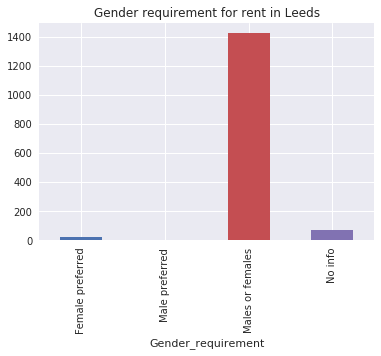

In [12]:
gender_group_leeds = df_info_leeds.groupby('Gender_requirement')
gender_group_leeds.size().plot(kind='bar', title='Gender requirement for rent in Leeds')

<h3>To see if there is more furnished apartment in Leeds

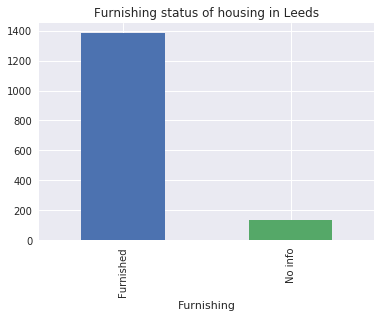

In [14]:
furnish_group_leeds = df_info_leeds.groupby('Furnishing')
furnish_group_leeds.size().plot(kind='bar', title='Furnishing status of housing in Leeds')

<h3>To see the size distribution in Leeds

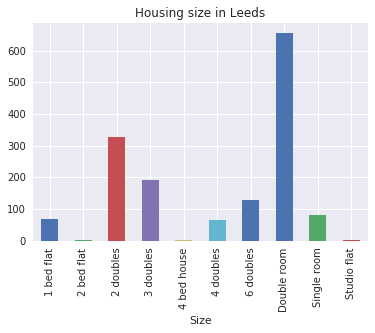

In [15]:
size_group_leeds = df_info_leeds.groupby('Size')
size_group_leeds.size().plot(kind='bar', title='Housing size in Leeds')

<h3>To see the average per-month price change

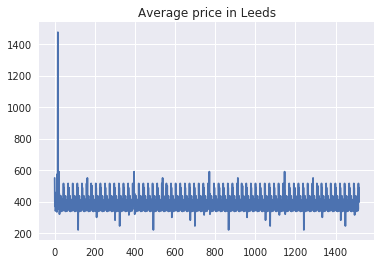

In [16]:
df_info_leeds['Average_price_per_month'].plot(kind='line', title='Average price in Leeds')

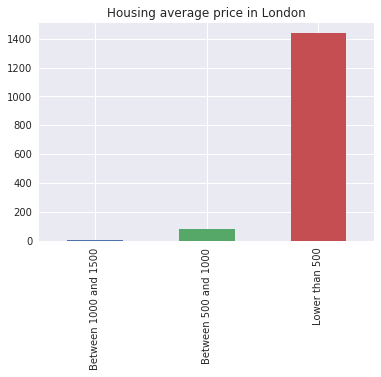

In [18]:
# Group the average price
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] < 500:
        return 'Lower than 500'
    elif 1000 > df[col].loc[ind] >= 500:
        return 'Between 500 and 1000'
    elif 1500 > df[col].loc[ind] >= 1000:
        return 'Between 1000 and 1500'
    else:
        return 'Above 1500'
avg_price_group = df_info_leeds.groupby(lambda x: GroupColFunc(df_info_leeds, x, 'Average_price_per_month')) 
avg_price_group.size().plot(kind='bar', title='Housing average price in London')
# Add a col of average price group for further analysis
avg_price_list = list()
for i in df_info_leeds.index:
    avg_price_list.append(GroupColFunc(df_info_leeds, i, 'Average_price_per_month'))
df_info_leeds['Avg_price_group'] = np.array(avg_price_list)

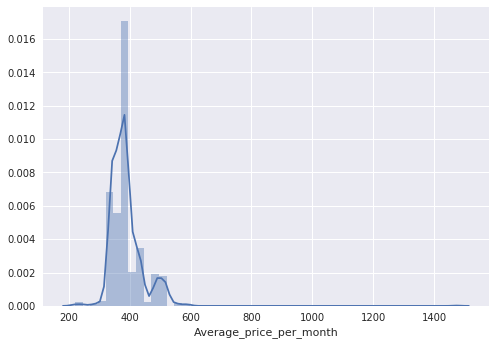

In [82]:
sns.distplot(df_info_leeds['Average_price_per_month'])

In [22]:
# Group by both size and average price
size_avg_groups_leeds = df_info_leeds.groupby(['Size','Avg_price_group']).size().unstack()
size_avg_groups_leeds

Avg_price_group,Between 1000 and 1500,Between 500 and 1000,Lower than 500
Size,,,
1 bed flat,NaN,4.0,65.0
2 bed flat,NaN,1.0,NaN
2 doubles,NaN,NaN,326.0
3 doubles,NaN,NaN,192.0
4 bed house,1.0,NaN,NaN
4 doubles,NaN,NaN,65.0
6 doubles,NaN,1.0,128.0
Double room,NaN,74.0,580.0
Single room,NaN,NaN,80.0


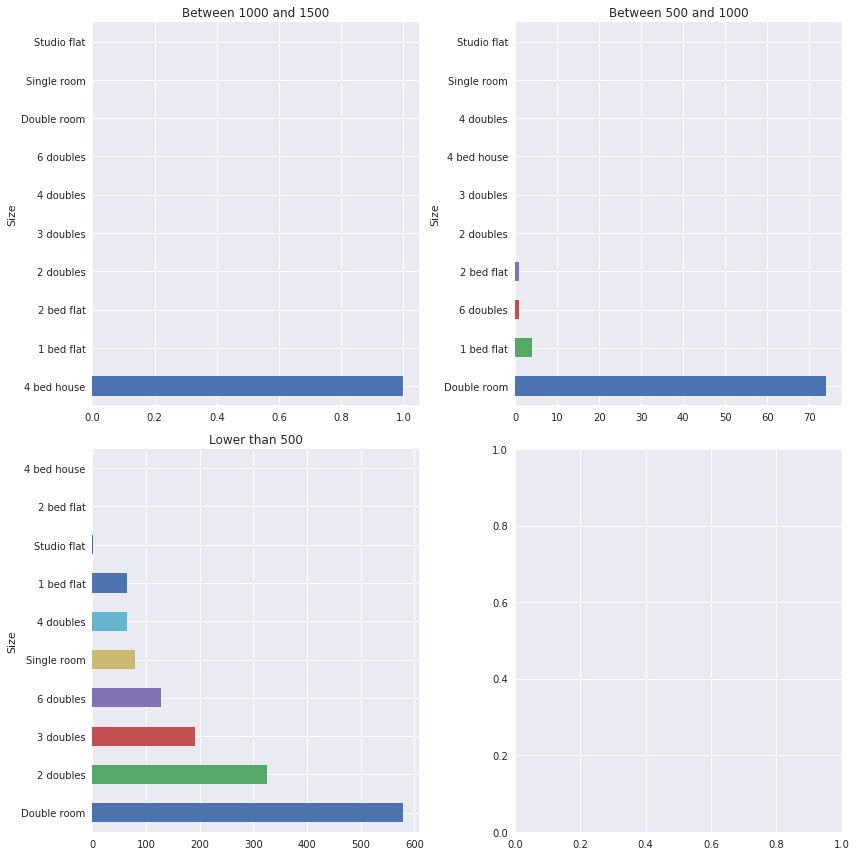

In [23]:
COL_NUM = 2
ROW_NUM = 2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (avg, size) in enumerate(size_avg_groups_leeds.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    size = size.sort_values(ascending=False) # sort the data in descending order 
    size.plot(kind='barh', ax=ax)
    ax.set_title(avg)

plt.tight_layout() 

<h1>heat map for house numbers

In [24]:
m = folium.Map(location = [53.8008, 1.5491],zoom_start=10)

In [26]:
zip_groups = df_info_leeds.groupby('Postal_code')
sizes = pd.DataFrame(zip_groups.size())
sizes.rename(columns={0:"size"},inplace=True)# Rename the col besides index to 'size'
sizes.reset_index(level=0, inplace=True)# level 0 here means no index,the index becomes row number
sizes['Zip'] = sizes['Postal_code']
sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Postal_code    15 non-null object
size           15 non-null int64
Zip            15 non-null object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes


In [27]:
sizes

,Postal_code,size,Zip
0,LS1,4,LS1
1,LS10,4,LS10
2,LS12,6,LS12
3,LS13,260,LS13
4,LS16,2,LS16
5,LS2,5,LS2
6,LS27,73,LS27
7,LS28,1,LS28
8,LS3,9,LS3
9,LS4,132,LS4


In [29]:
# read the geojson file and get all the postcode
with open("leeds_postcodes.geojson",'r') as load_f:
    load_dict = json.load(load_f)

full_pos = list()
for item in load_dict['features']:
    full_pos.append(item['properties']['Name'])

In [30]:
df_zip = pd.DataFrame(np.array([full_pos])).T
df_zip = df_zip.rename(columns={0:'Zip_code'})

In [31]:
zip_size = list()
for i in df_zip.index:
    for j in sizes.index:
        if df_zip.iloc[i]['Zip_code'] == sizes.iloc[j]['Zip']:
            zip_size.append(sizes.iloc[j]['size'])
            break
        elif j == (len(sizes) - 1):
            zip_size.append(0)
df_zip['size'] = np.array(zip_size)  

In [37]:
m.choropleth(geo_data='leeds_postcodes.geojson', data=df_zip, 
             columns=['Zip_code','size'],
             key_on='feature.properties.name',
             fill_color='GnBu', fill_opacity=0.7, line_opacity=0.8,
             legend_name='Distribution of Incidents')
folium.LayerControl().add_to(m)

/usr/local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [38]:
m

<h1> Manchester

In [32]:
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Second type
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    # Third type
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
        housings_list.append([detail_dict,link])
    #     Turn to next page and get more housings
    if soup.find('ul',class_='navnext'):
        if soup.find('ul',class_='navnext').find('a'):
            next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
            next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
        # Use recursion to get all the attractions    
            housings_list.extend(get_housings(next_page))
    return housings_list

In [33]:
url_Manchester = 'https://www.spareroom.co.uk/flatshare/?search_id=749193487&'
list_Manchester = get_housings(url_Manchester)
print(f'We have find {len(list_Manchester)} results for you.')

We have find 1007 results for you.


In [34]:
def get_details(list_leeds):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_leeds:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        if not price_list:
            if soup.find('section', class_='feature feature--price-whole-property'):
                price = soup.find('h3', class_='feature__heading')
                price_list.append(price.get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
#     return price_list
    return full_dict

In [35]:
detail_Manchester = get_details(list_Manchester)

<h3> Clean the data

In [6]:
# Create a function for the above:
def clean(dict_):
    for key in dict_.keys():
        for subkey in dict_[key].keys():
            if isinstance(dict_[key][subkey], str):
                dict_[key][subkey] = dict_[key][subkey].lstrip().rstrip()
    # Clean the price list
    for key in dict_.keys():
        list_in = list()
        for item in list(dict_[key]['Price']):
            list_in.append(item.strip('\n'))
        dict_[key]['Price'] = list_in
        
    df_info = pd.DataFrame(dict_)
    df_info = df_info.T

    # Fix furnished problem
    for i in df_info.index:
        if df_info.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
            pass
        else:
            df_info.iloc[i]['Furnishing'] = 'No info'
    # Fix Gender_requirement problem
    for i in df_info.index:
        if df_info.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info','Male preferred']:
            pass
        else:
            df_info.iloc[i]['Gender_requirement'] = 'No info'
    # Create a new col in df_info to store average price for a single person
    pattern = r'\d+'  
    price_per_month = list()

    for i in df_info.index:
        list_in_price = list()
        for item in df_info.iloc[i]['Price']:
            item = item.replace(',', '')
            if 'pw' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info*4)
            if 'pcm' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info)
        price_per_month.append(list_in_price)
    price_per_month = np.array(price_per_month)
    df_info['Price_per_month'] = price_per_month
    list_avg_price = list()
    for i in df_info.index:
        list_avg_price.append(np.mean(df_info.iloc[i]['Price_per_month']) )
    df_info['Average_price_per_month'] = np.array(list_avg_price)
    # Create a new col in df_info to store zip code for each housing
    # Create a new col for zip code
    list_pos = list()
    for i in df_info.index:
        for s in df_info.iloc[i]['Location']:
            if s == '(':
                position = df_info.iloc[i]['Location'].index(s)
                break
        list_pos.append(df_info.iloc[i]['Location'][position:].strip('(').strip(')'))
    df_info['Postal_code'] = np.array(list_pos)
    return df_info
      

In [7]:
df_info = clean(detail_Manchester)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<h3> Data Visualization

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')# seaborn is a style that have different colors

<h4> To see if there is a gender preference in Manchester

In [84]:
gender_group = df_info.groupby('Gender_requirement')
gender_size = gender_group.size()
title = 'Gender requirement for rent in Manchester'

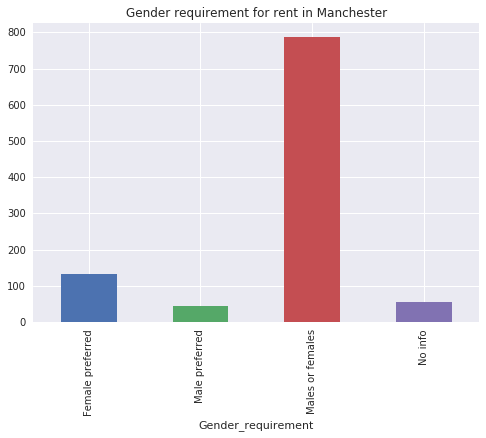

In [85]:
# bar chart
gender_size.plot(kind='bar', title=title)

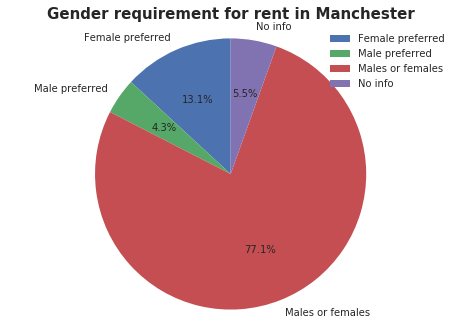

In [86]:
# pie chart
label = gender_size.index
fig1, ax1 = plt.subplots()
ax1.pie(gender_size, labels = label, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(title, fontsize=15, fontweight='bold')
plt.legend()
plt.show()

<h4> To see the housing condition in postal code area in Manchester

In [89]:
Postal_code_group = df_info.groupby('Postal_code')
postal_size = Postal_code_group.size()
title = 'Postal code area in Manchester'

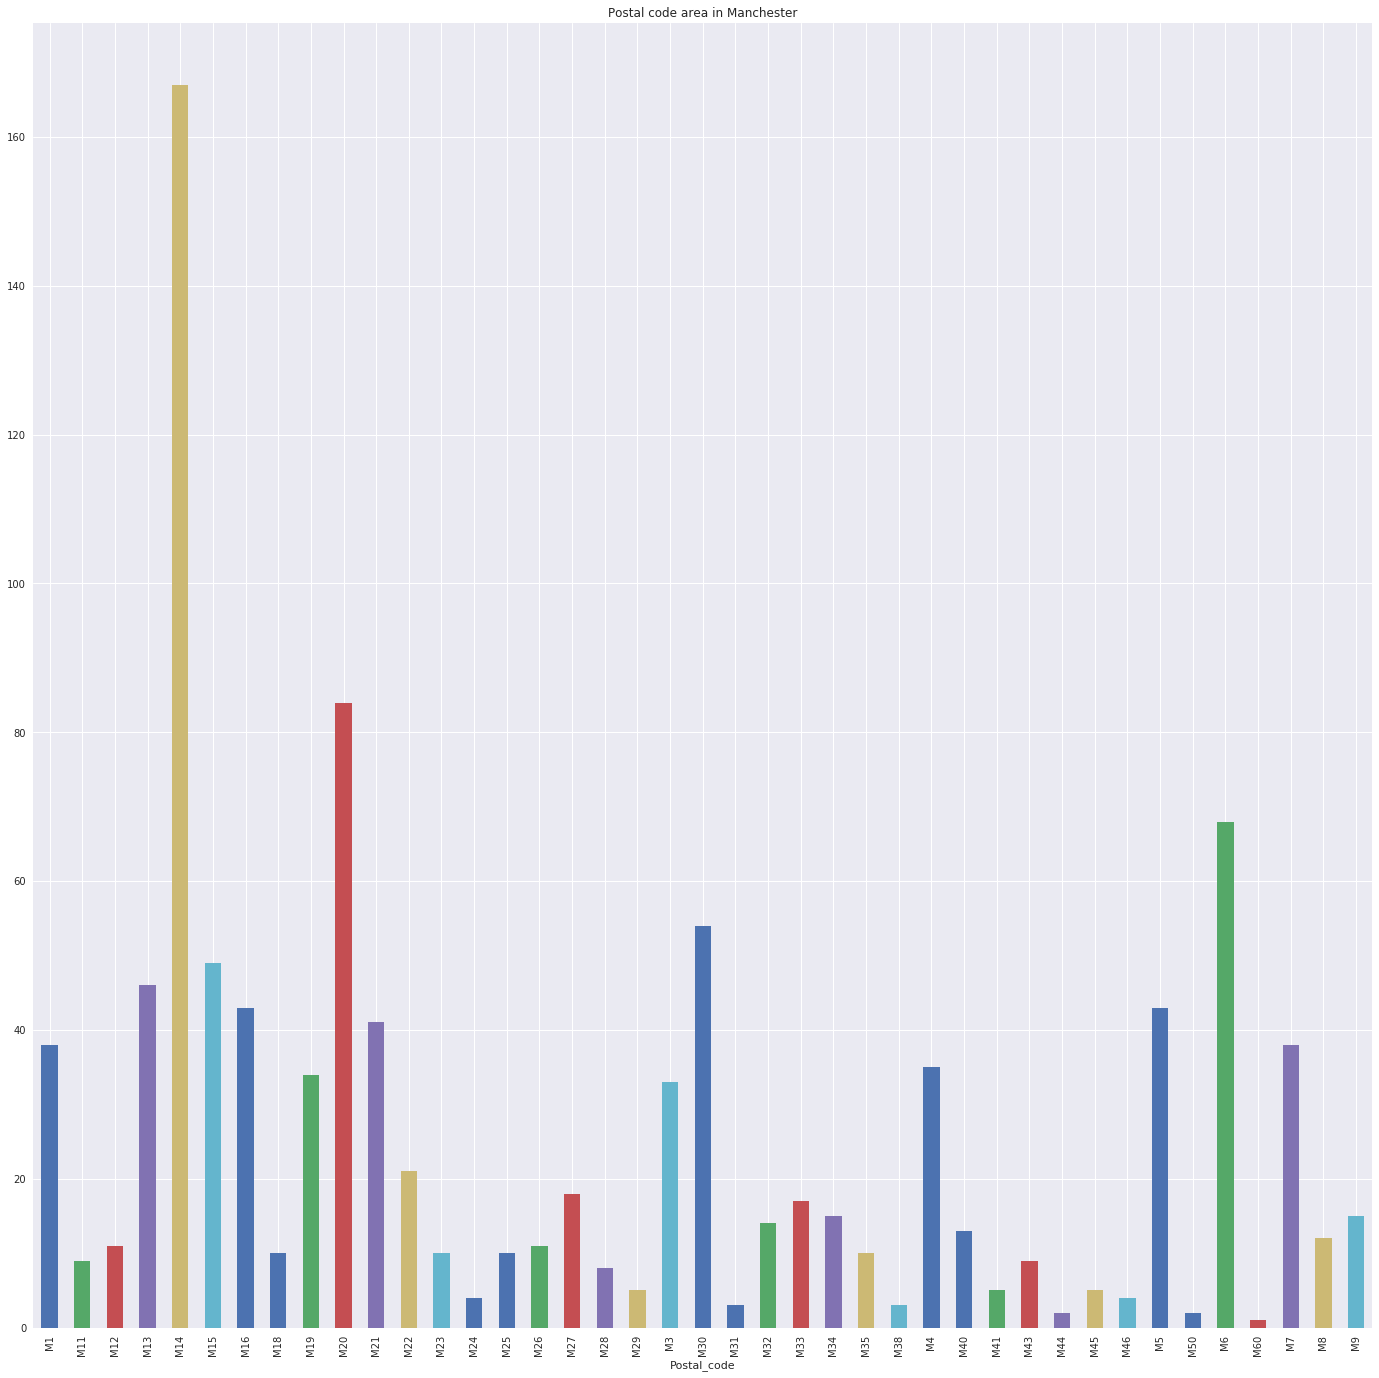

In [90]:
postal_size.plot(kind='bar', title='Postal code area in Manchester', figsize=(24,24))

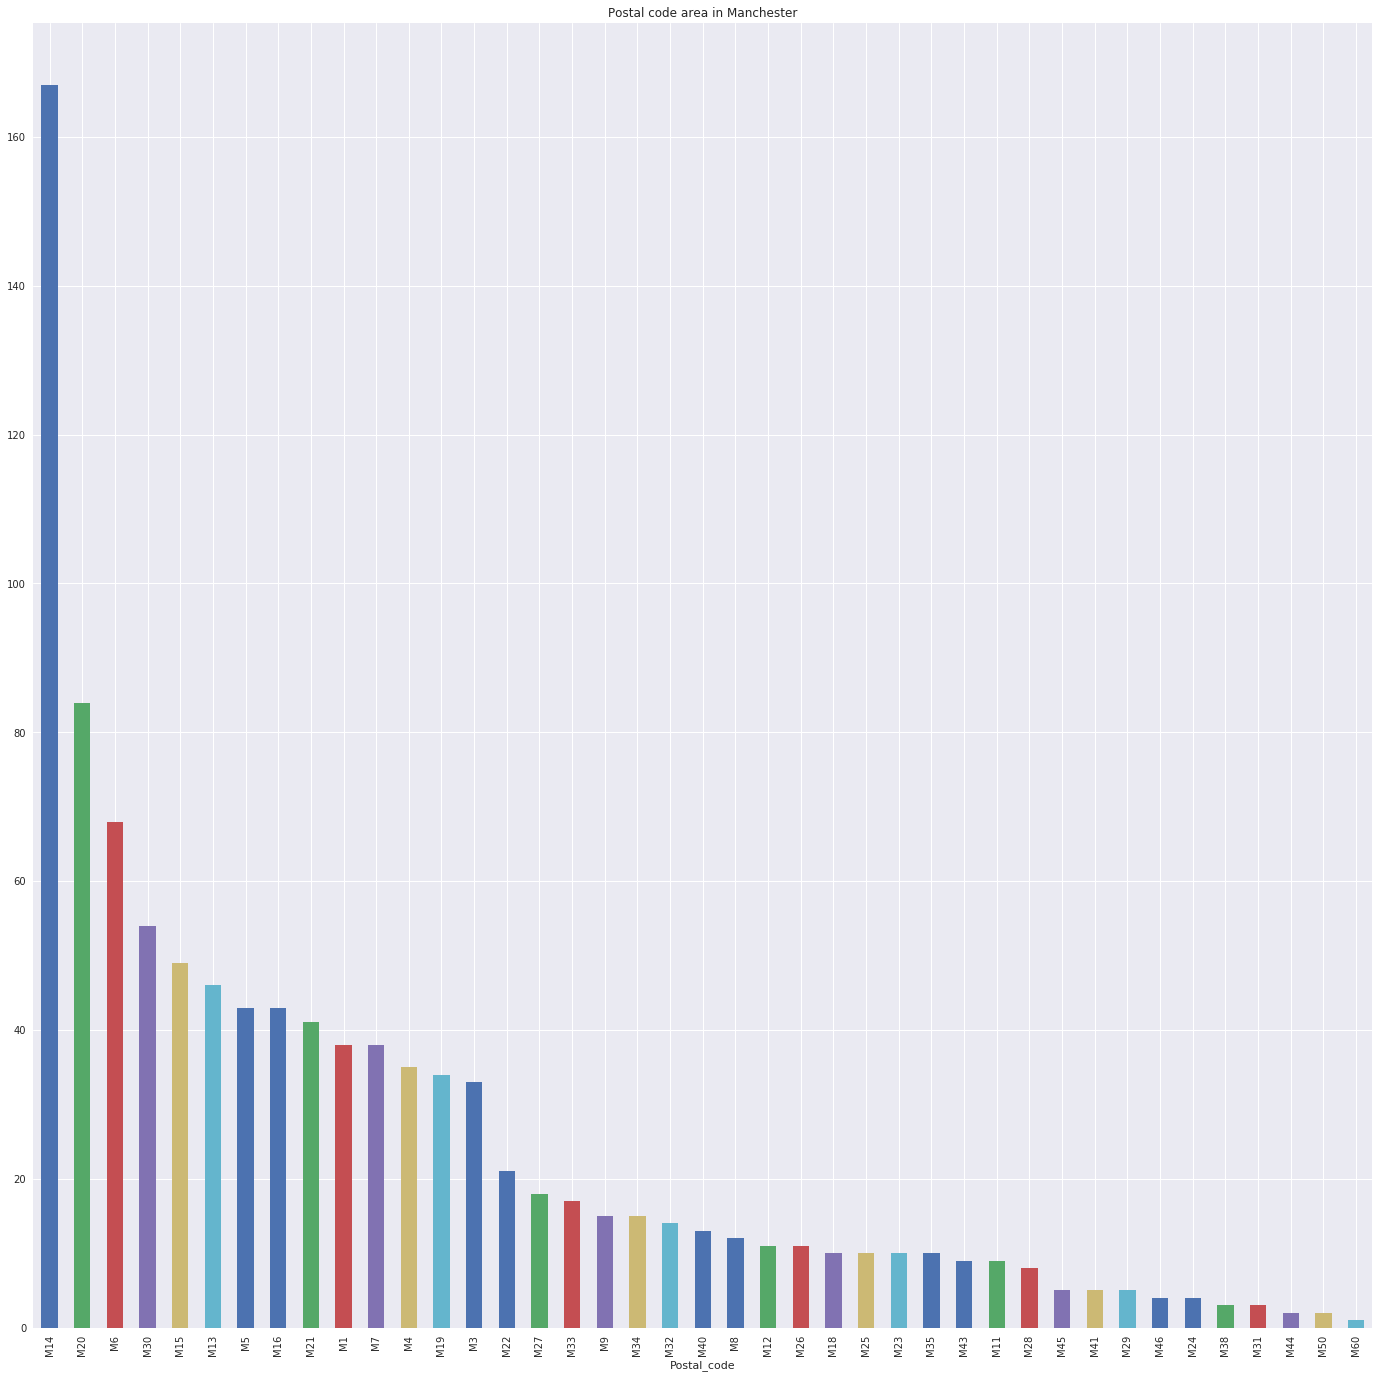

In [91]:
# plot by descending
postal_size.sort_values(ascending=False).plot(kind='bar', title='Postal code area in Manchester', figsize=(24,24))

<h4> To see if there is more furnished apartment in Manchester

In [94]:
furnish_group = df_info.groupby('Furnishing')
furnish_size = furnish_group.size()
title = 'Furnishing status of housing in Manchester'

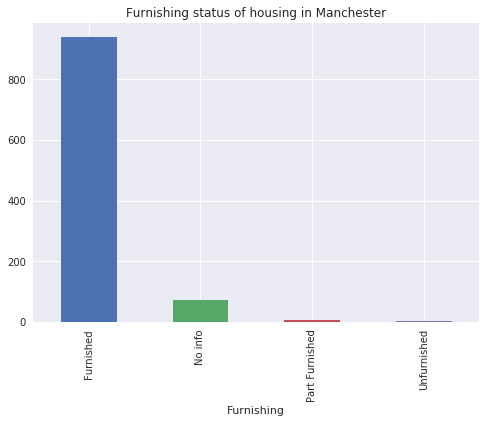

In [95]:
# bar chart
furnish_size.plot(kind='bar', title=title)

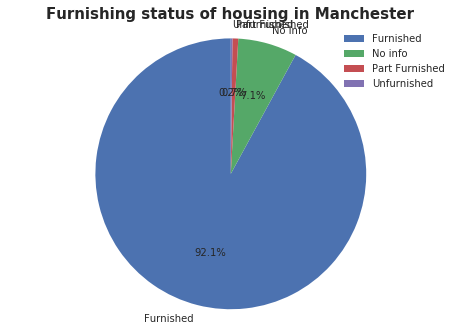

In [96]:
# pie chart
label = furnish_size.index
fig1, ax1 = plt.subplots()
ax1.pie(furnish_size, labels = label, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(title, fontsize=15, fontweight='bold')
plt.legend()
plt.show()

<h4> To see the size distribution in Manchester

In [99]:
size_group = df_info.groupby('Size')
size_size = size_group.size()
title = 'Housing size in Manchester'

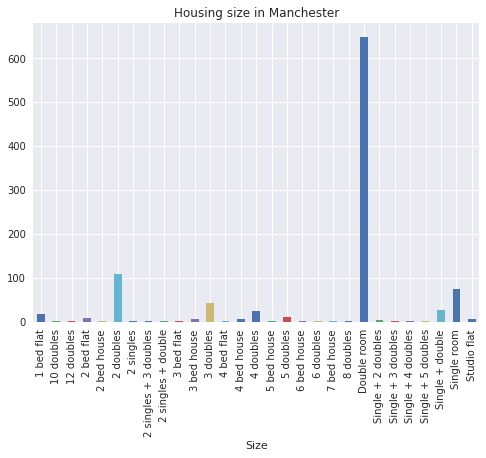

In [101]:
# bar chart
size_size.plot(kind='bar', title=title)

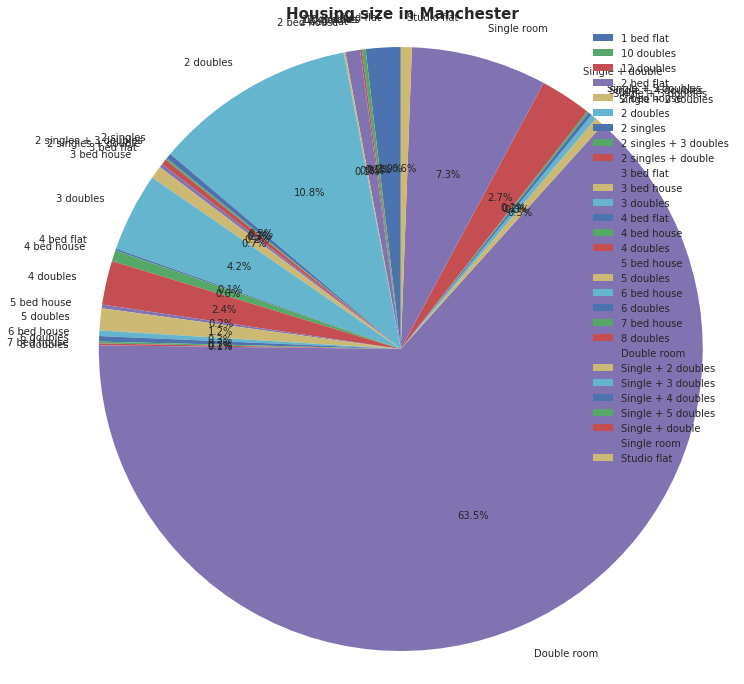

In [107]:
# pie chart
label = size_size.index
fig1, ax1 = plt.subplots(figsize=(12,12))
ax1.pie(size_size, labels = label, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(title, fontsize=15, fontweight='bold')
plt.legend()
plt.show()

<h4> To see the average per-month price change

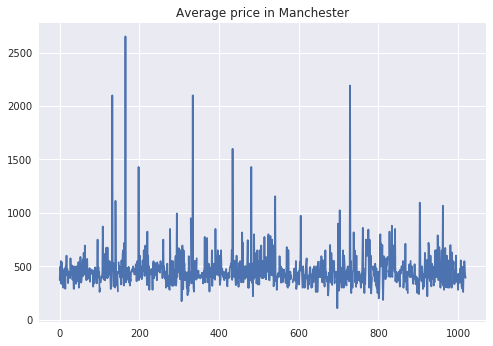

In [109]:
df_info['Average_price_per_month'].plot(kind='line', title='Average price in Manchester')

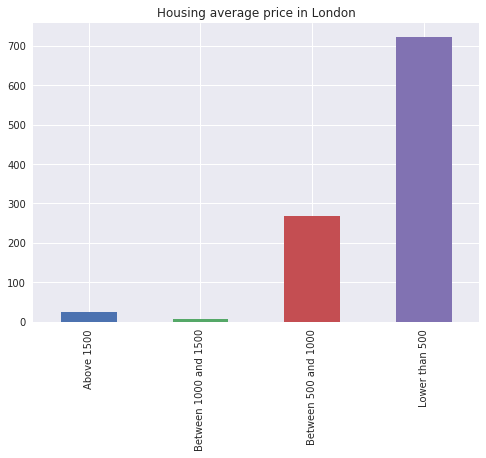

In [110]:
# Group the average price
def GroupColFunc(df, ind, col):
    if df[col].loc[ind] < 500:
        return 'Lower than 500'
    elif 1000 > df[col].loc[ind] >= 500:
        return 'Between 500 and 1000'
    elif 1500 > df[col].loc[ind] >= 1000:
        return 'Between 1000 and 1500'
    else:
        return 'Above 1500'
avg_price_group = df_info.groupby(lambda x: GroupColFunc(df_info, x, 'Average_price_per_month')) 
avg_price_group.size().plot(kind='bar', title='Housing average price in London')
# Add a col of average price group for further analysis
avg_price_list = list()
for i in df_info.index:
    avg_price_list.append(GroupColFunc(df_info, i, 'Average_price_per_month'))
df_info['Avg_price_group'] = np.array(avg_price_list)

In [111]:
# Group by both size and average price
size_avg_groups = df_info.groupby(['Size','Avg_price_group']).size().unstack()

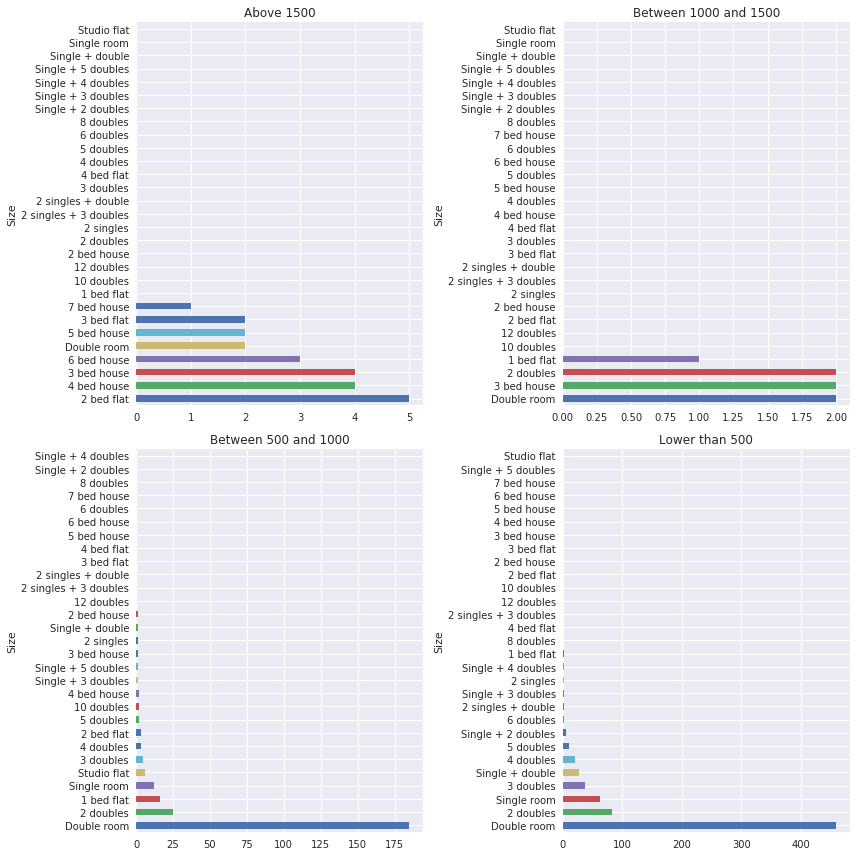

In [112]:
COL_NUM = 2
ROW_NUM = 2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

for i, (avg, size) in enumerate(size_avg_groups.items()): 
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    size = size.sort_values(ascending=False) # sort the data in descending order 
    size.plot(kind='barh', ax=ax)
    ax.set_title(avg)

plt.tight_layout() 

<h3> Heat Map

In [280]:
zip_groups = df_info.groupby('Postal_code')

sizes = zip_groups.size()
sizes = sizes.rename("size")
avg_price = zip_groups.Average_price_per_month.mean()
info_group_by_zip = pd.concat([sizes, avg_price], axis = 1)
info_group_by_zip['zip'] = info_group_by_zip.index

In [282]:
# read the geojson file and get all the postcode
with open("manchester_postcodes.geojson",'r') as load_f:
    geojson = json.load(load_f)

# drop zip zone that we don't have data in geojson
geojson['features'] = [item for item in geojson['features'] if item['properties']['Name'] in info_group_by_zip.index]

In [307]:
# 
m = folium.Map(location = [53.483959, -2.244644],zoom_start=10)
m.choropleth(geo_data=geojson, data=info_group_by_zip, 
             columns=['zip','size'],
             key_on='feature.properties.Name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='the number of housings')
folium.LayerControl().add_to(m)

In [309]:
print (m)

In [305]:
m = folium.Map(location = [53.483959, -2.244644],zoom_start=10)
m.choropleth(geo_data=geojson, data=info_group_by_zip, 
             columns=['zip','Average_price_per_month'],
             key_on='feature.properties.Name',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
             legend_name='average housing price')
folium.LayerControl().add_to(m)

In [306]:
m

<h1> Create a blueprint for all the four cities

In [ ]:
class rental:
    def __init__(self, url, location):
        self.location = location
        self.url = url
        self.dict_ = get_details(get_housings(self.url))
    @property
    def df(self):
        return clean(self.dict_)
    def bar_chart(self, group):# only for simple group function, cannot be used for graph with two groupings. 
        # group here is for the name of one column in the df that you want to use groupby function.
        %matplotlib inline
        import matplotlib.pyplot as plt
        plt.style.use('seaborn')
        self.group = self.df.groupby(str(group))
        return self.group.size().plot(kind='bar', title=f'{group} for rent in {self.location}')
    def heat_map(self):
        return map_rent(self.location, self.df)

In [ ]:
london = rental('https://www.spareroom.co.uk/flatshare/?search_id=745817425&', 'london')

In [ ]:
london.df

In [ ]:
london.graph('Size')

In [ ]:
london.heat_map()